From https://joaofaria.space/blog/continuous-samples

In [1]:
from imports import *
from george import GP
from george.kernels import *
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# print kernels
[k for k in dir() if 'Kernel' in k]

['ConstantKernel',
 'CosineKernel',
 'DotProductKernel',
 'ExpKernel',
 'ExpSine2Kernel',
 'ExpSquaredKernel',
 'Kernel',
 'Matern32Kernel',
 'Matern52Kernel',
 'PythonKernel',
 'RadialKernel',
 'WhiteKernel']

In [3]:
# define continuous GP object
class GPc(object):
    def __init__(self, kernel, x):
        self.gp = GP(kernel)
        self.stepState = 0
        
        self.z = self.gp.sample(x)
        self.p = self.gp.sample(x)
        
    def sample_independent(self, x):
        self.z = self.gp.sample(x)
        return self.z
    
    def sample_continuous(self, x, alpha=0.3, Nsteps=15, stepsize=np.pi):
        alpha = 1. - alpha
        t = stepsize / Nsteps
        self.stepState = self.stepState % Nsteps
        if self.stepState == Nsteps-1: # refresh momentum
            self.p = alpha*self.p + np.sqrt(1-alpha**2)*self.gp.sample(x)
            
        a = self.p; b = self.z; c = -self.z; d = self.p
        self.z = a * np.sin(t) + b * np.cos(t)
        self.p = c * np.sin(t) + d * np.cos(t)
        self.stepState += 1
        return self.z

In [4]:
# define continuous GP object
class GPc_pred(object):
    def __init__(self, kernel, x, y, ey, xpred):
        self.gp = GP(kernel)
        self.stepState = 0
        
        self.gp.compute(x, ey)
        self.z = self.gp.sample_conditional(y,xpred)
        self.p = self.gp.sample_conditional(y,xpred)
        
    def sample_independent(self, xpred, y):
        self.z = self.gp.sample_conditional(y,xpred)
        return self.z
    
    def sample_continuous(self, xpred, y, alpha=0.3, Nsteps=15, stepsize=np.pi):
        alpha = 1. - alpha
        t = stepsize / Nsteps
        self.stepState = self.stepState % Nsteps
        if self.stepState == Nsteps-1: # refresh momentum
            self.p = alpha*self.p + np.sqrt(1-alpha**2)*self.gp.sample_conditional(y,xpred)
            
        a = self.p; b = self.z; c = -self.z; d = self.p
        self.z = a * np.sin(t) + b * np.cos(t)
        self.p = c * np.sin(t) + d * np.cos(t)
        self.stepState += 1
        return self.z

In [37]:
# define GP
#a, l, G, P = 1., 100, .5, 50
a, l, G, P = 1., 73.4, .236, 50
kernel = a*ExpSquaredKernel(l)*ExpSine2Kernel(G,P)
x = np.linspace(0,1e2,5e2)
np.random.seed(1)
xm = np.sort(np.random.uniform(0,1e2,10))+2
sig = .4
ym = np.sin(2*np.pi*xm/P) - .005*xm + np.random.randn(xm.size)*sig
ey = np.repeat(sig,xm.size)
#g = GPc(kernel, x)
g = GPc_pred(kernel, xm, ym, ey, x)

/Users/ryancloutier/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


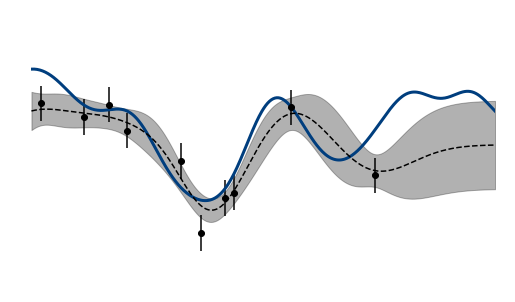

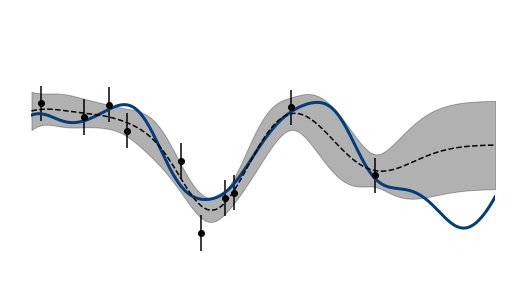

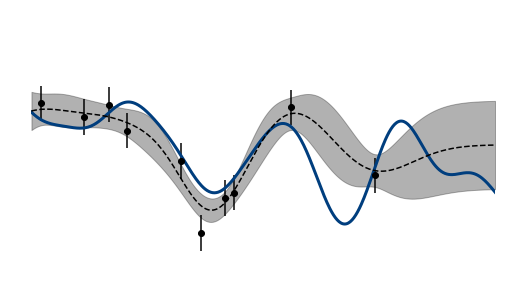

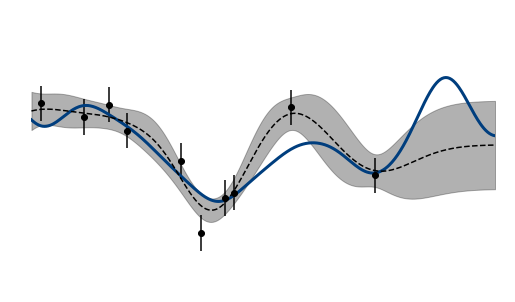

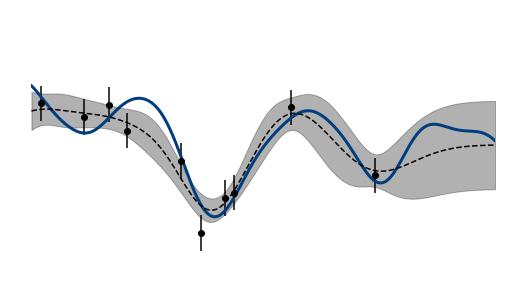

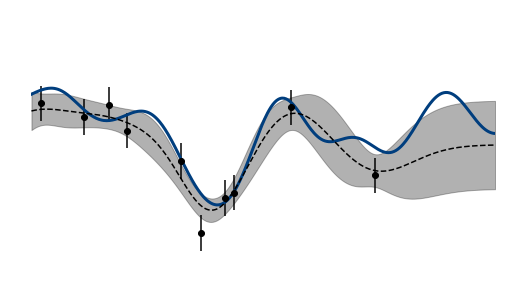

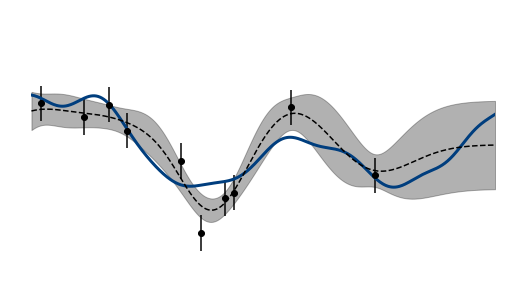

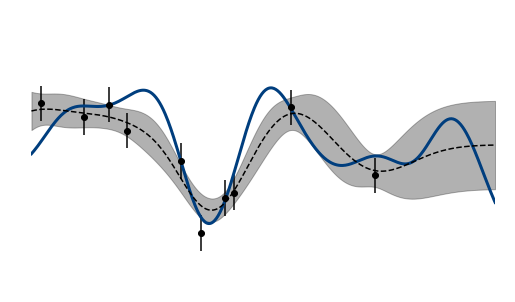

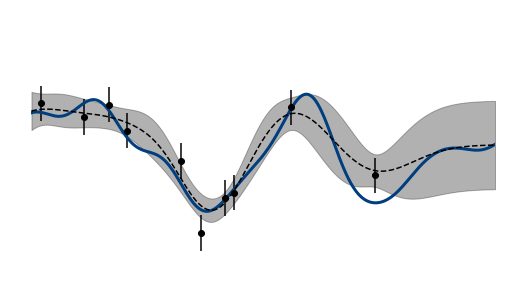

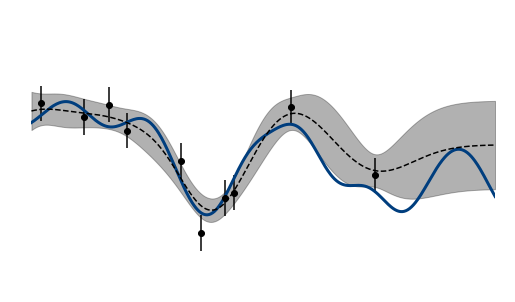

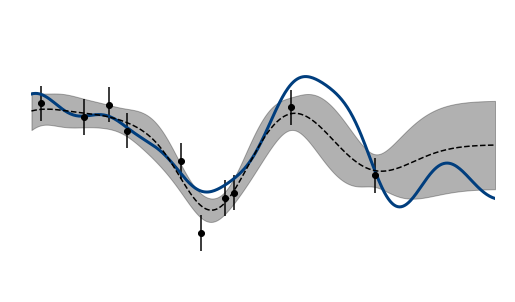

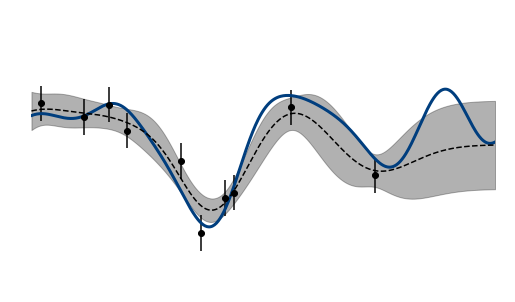

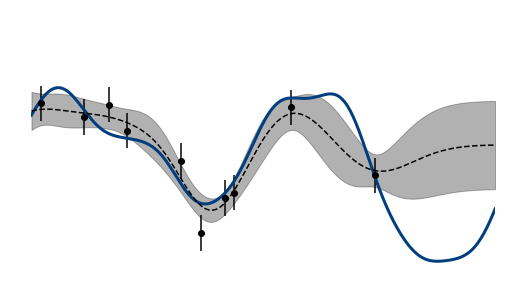

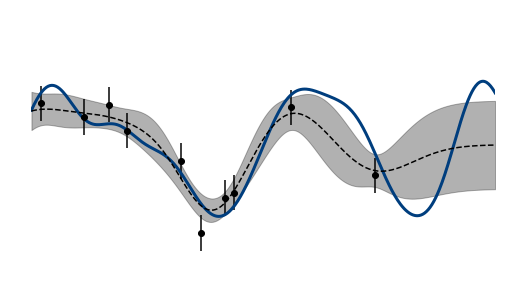

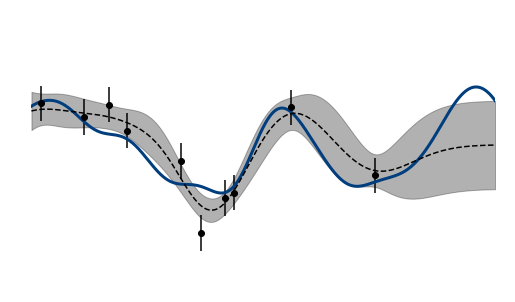

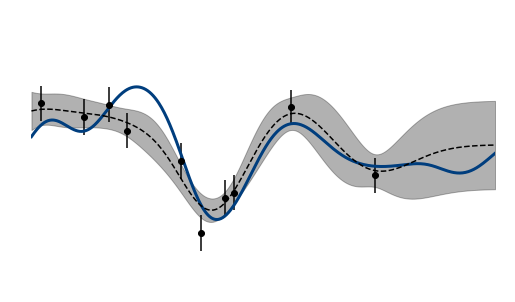

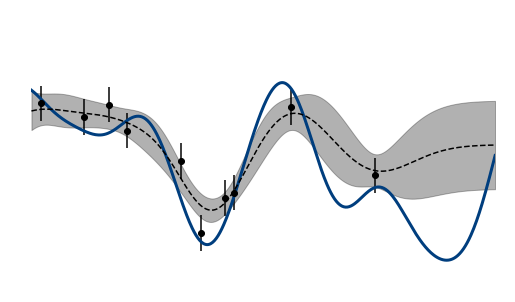

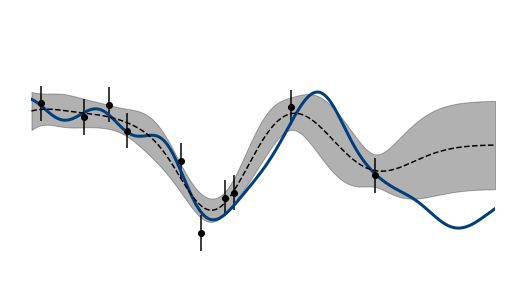

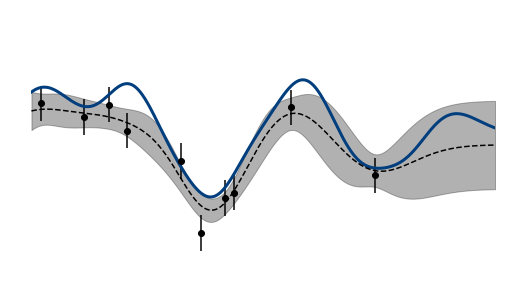

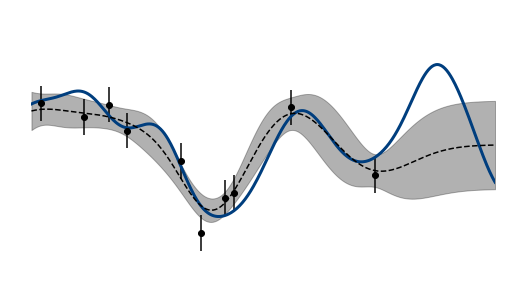

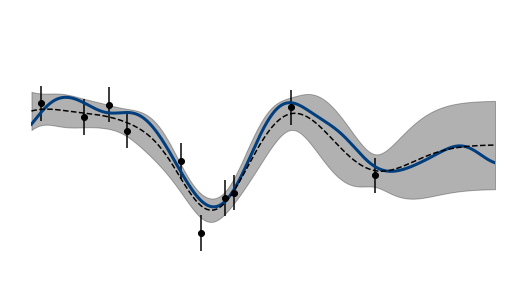

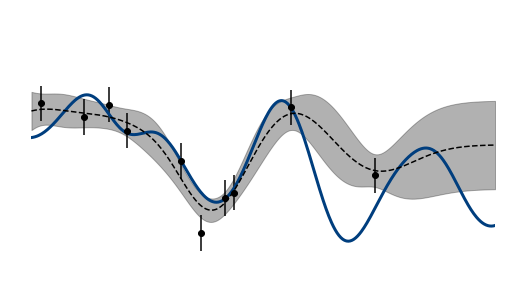

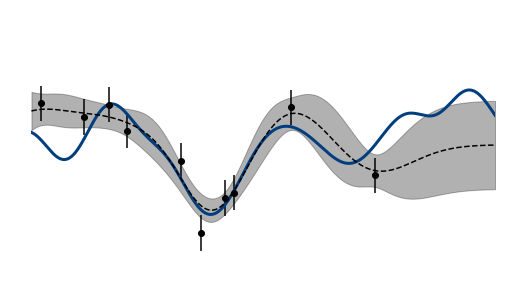

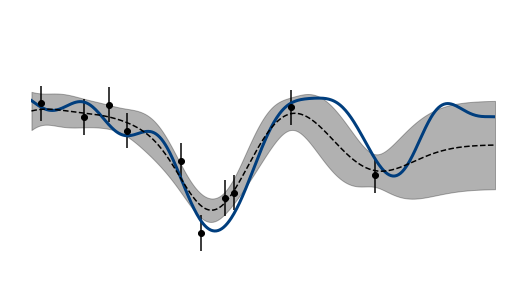

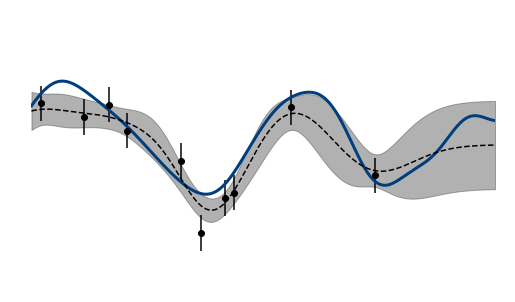

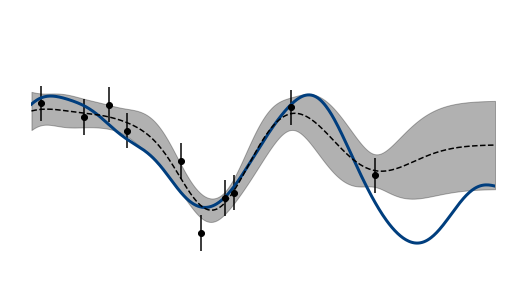

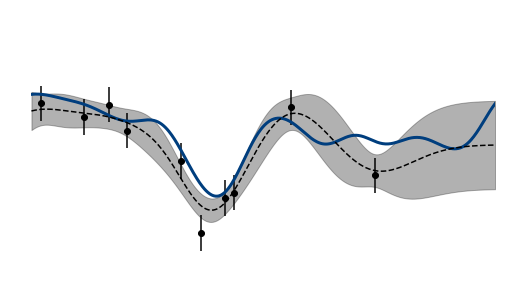

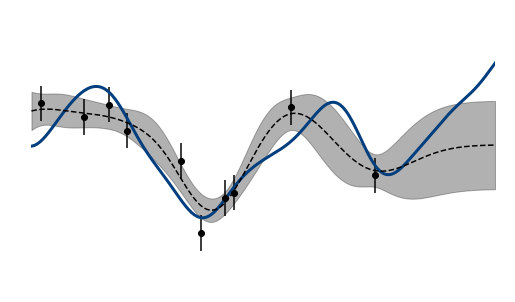

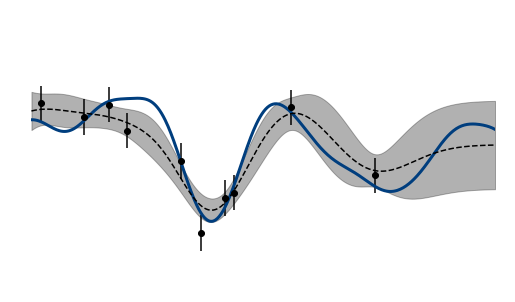

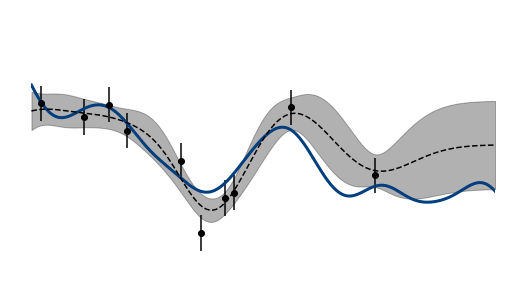

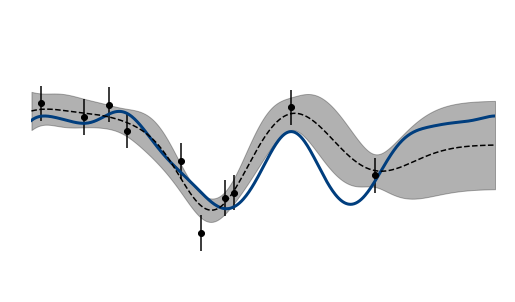

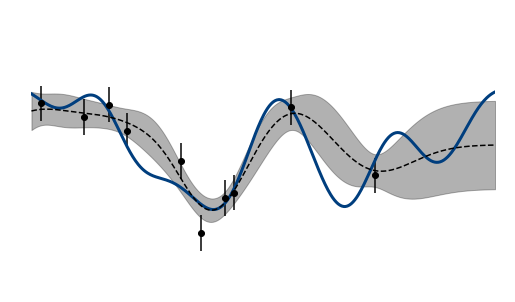

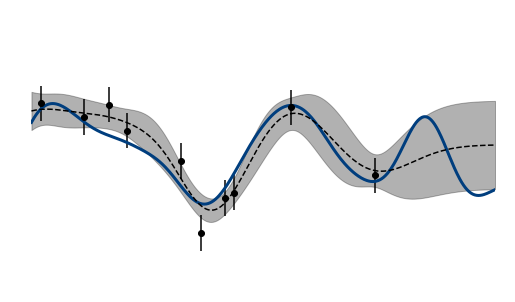

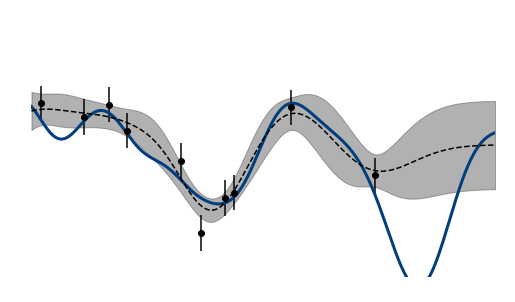

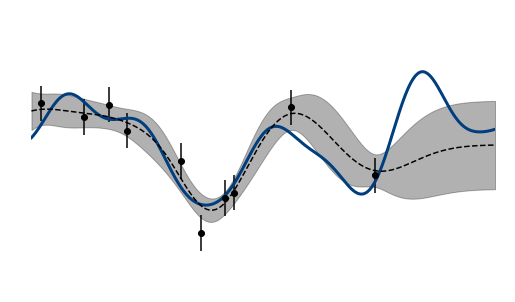

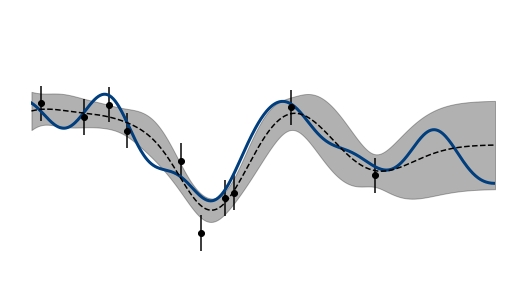

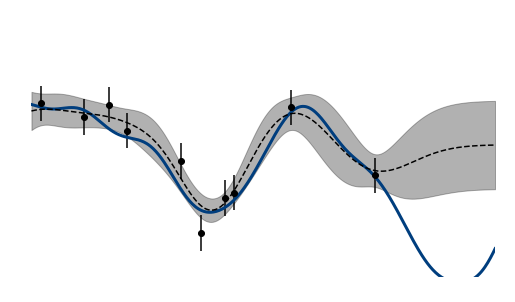

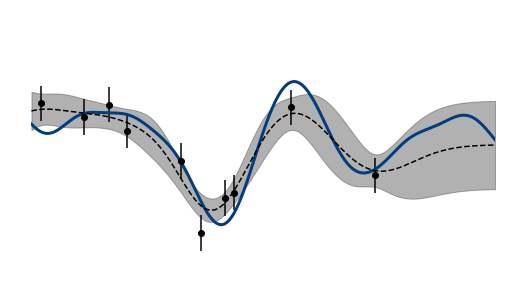

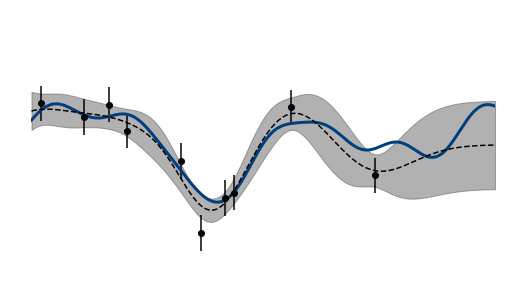

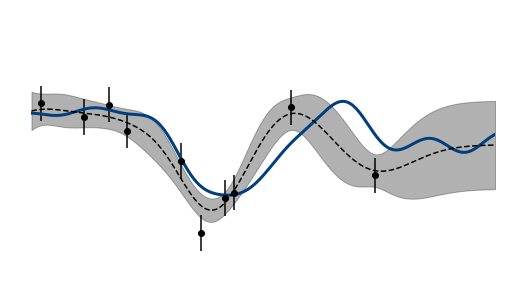

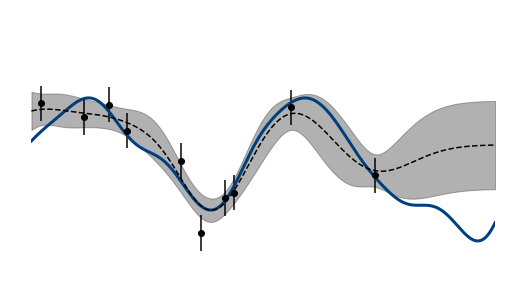

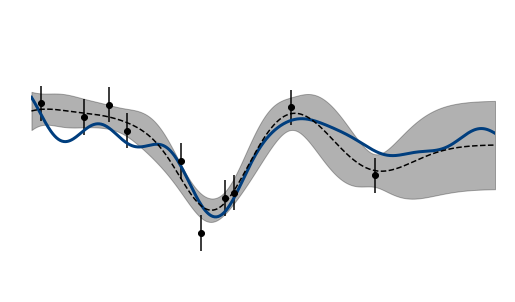

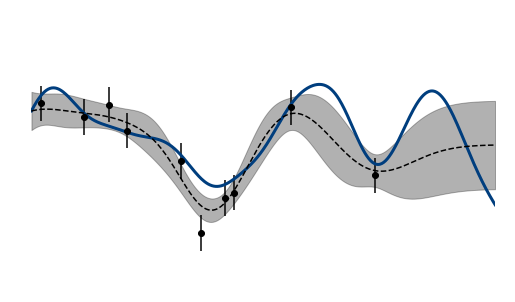

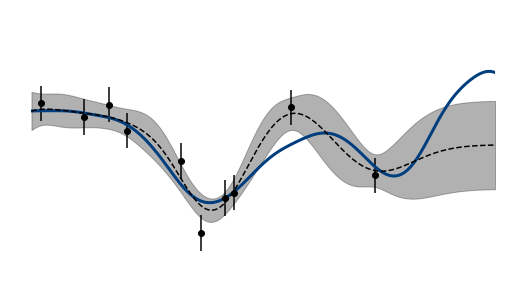

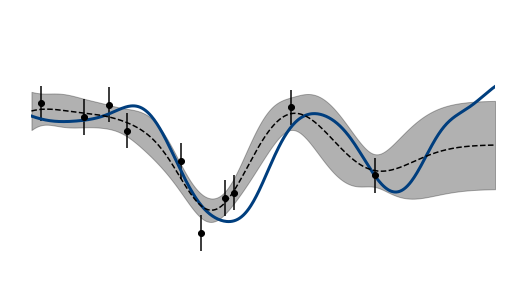

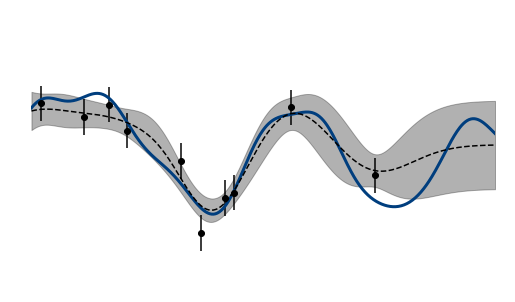

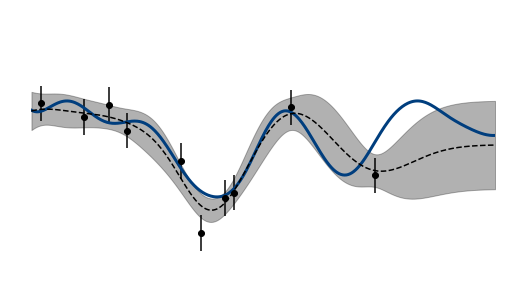

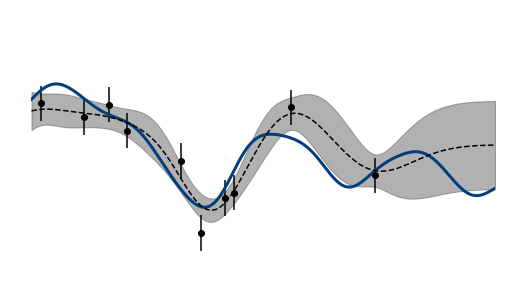

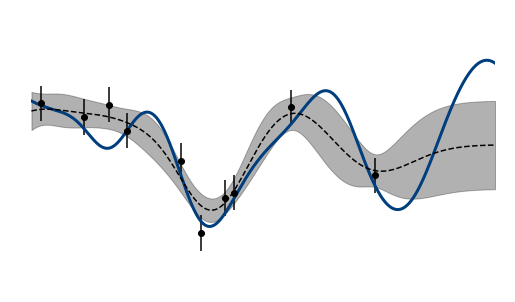

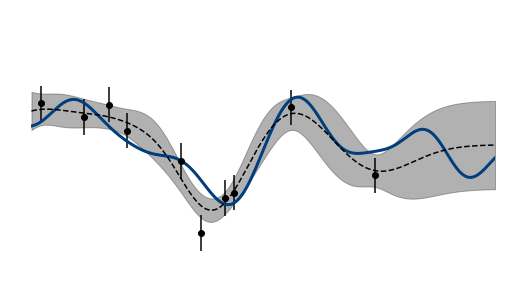

In [48]:
N = 50
np.random.seed(1)
for i in range(N):
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(111)
    ax.plot(x, g.sample_independent(x,ym), '-', lw=3, c='#003E7E')
    mu,cov = g.gp.predict(ym, x)
    sig = np.sqrt(np.diag(cov))
    ax.fill_between(x, mu-sig, mu+sig, alpha=.3, color='k')
    ax.plot(x, g.gp.predict(ym,x,mean_only=True), 'k--')
    ax.errorbar(xm, ym, ey, fmt='ko')
    ax.set_xlim((0,100)), ax.set_ylim((-3,3))
    ax.axis('off')
    fig.subplots_adjust(bottom=.04, left=.04, top=.96, right=.96)
    plt.savefig('/Users/ryancloutier/Research/Thesis/thesis/figures/GPsample_pred_%i.png'%i)